#  Book Recommendation System with Association Rules

This notebook uses Apriori and association rule mining to build a book recommendation system based on reader checkout patterns.

## 1. Setup and Imports

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Import MLxtend for association rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')


os.makedirs('association_rules_results', exist_ok=True)


## 2. Data Loading and Exploration

In [4]:
# Load transaction data
df_long = pd.read_excel('processed_data/transactions_long_format.xlsx')

print("Dataset Overview")
print("=" * 60)
print(f"Shape: {df_long.shape}")
print(f"\nColumns: {df_long.columns.tolist()}")
print(f"\nFirst few rows:")
df_long.head(10)

Dataset Overview
Shape: (270, 2)

Columns: ['reader_id', 'book_title']

First few rows:


,reader_id,book_title
0,5817912,exercices corrigés d'analyse : 1ère année lmd
1,5754033,exercices d'algèbre et d'analyse : 154 exercic...
2,5113394,exercices d'algèbre et d'analyse : 154 exercic...
3,6092419,exercices d'algèbre et d'analyse : 154 exercic...
4,8354464,exercices et problèmes d'algorithmique : 144 é...
5,33,"mathématiques, ec 1re année : tout-en-un : cou..."
6,6243736,maths pcsi-ptsi
7,5868325,maths pcsi-ptsi
8,3825689,maths pcsi-ptsi : 1re année
9,4846540,"maths, mpsi"


In [5]:
# Basic statistics
print("Dataset Statistics")
print("=" * 60)
print(f"Total records: {len(df_long)}")
print(f"Unique readers: {df_long['reader_id'].nunique()}")
print(f"Unique books: {df_long['book_title'].nunique()}")
print(f"\nAverage books per reader: {len(df_long) / df_long['reader_id'].nunique():.2f}")

Dataset Statistics
Total records: 270
Unique readers: 119
Unique books: 101

Average books per reader: 2.27


In [6]:
# Convert to transaction format (list of lists)
transactions = df_long.groupby('reader_id')['book_title'].apply(list).tolist()

print(f"Total number of transactions: {len(transactions)}")
print(f"\nSample transactions:")
for i, trans in enumerate(transactions[:3], 1):
    print(f"\nTransaction {i}: {len(trans)} books")
    for book in trans[:3]:
        print(f"  - {book}")
    if len(trans) > 3:
        print(f"  ... and {len(trans) - 3} more books")

Total number of transactions: 119

Sample transactions:

Transaction 1: 3 books
  - mathematical logic
  - logique mathématique : cours et exercices corrigés
  - 400 exercices corrigés d'algèbre avec rappels de cours pour spé mp-mp*

Transaction 2: 3 books
  - computer organization and architecture : designing for performance - global edition
  - cambridge english skills real listening and speaking 1
  - cambridge english skills real listening and speaking 2

Transaction 3: 3 books
  - mathématiques, ec 1re année : tout-en-un : cours et exercices
  - toutes les mathématiques, mp : 1re partie, le kit de survie, 2e partie, des cerises sur le gâteau
  - fonctions de plusieurs variables relles : imites,continuite,differentiabilité et.... cours détaillé et exercices résolus


## 3. Transaction Analysis

In [7]:
# Analyze transaction characteristics
transaction_sizes = [len(t) for t in transactions]
all_items = [item for transaction in transactions for item in transaction]
item_counts = Counter(all_items)

print("Transaction Statistics")
print("=" * 60)
print(f"Total transactions: {len(transactions)}")
print(f"Min transaction size: {min(transaction_sizes)}")
print(f"Max transaction size: {max(transaction_sizes)}")
print(f"Average transaction size: {np.mean(transaction_sizes):.2f}")
print(f"Median transaction size: {np.median(transaction_sizes):.0f}")
print(f"\nTotal unique books: {len(item_counts)}")
print(f"Total book checkouts: {len(all_items)}")

Transaction Statistics
Total transactions: 119
Min transaction size: 2
Max transaction size: 3
Average transaction size: 2.27
Median transaction size: 2

Total unique books: 101
Total book checkouts: 270


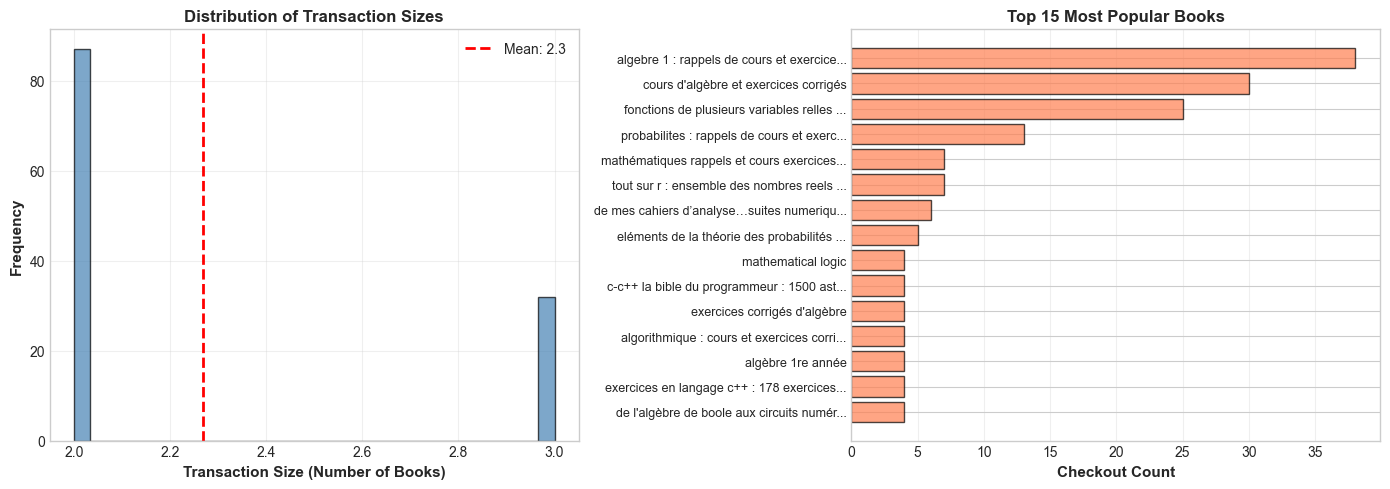


Top 10 Most Popular Books:
algebre 1 : rappels de cours et exercices avec sol | Count:  38 | Support: 0.319
cours d'algèbre et exercices corrigés              | Count:  30 | Support: 0.252
fonctions de plusieurs variables relles : imites,c | Count:  25 | Support: 0.210
probabilites : rappels de cours et exercices corri | Count:  13 | Support: 0.109
mathématiques rappels et cours exercices résolus   | Count:   7 | Support: 0.059
tout sur r : ensemble des nombres reels structures | Count:   7 | Support: 0.059
de mes cahiers d’analyse…suites numeriques : cours | Count:   6 | Support: 0.050
eléments de la théorie des probabilités t.1        | Count:   5 | Support: 0.042
mathematical logic                                 | Count:   4 | Support: 0.034
c-c++ la bible du programmeur : 1500 astuces pour  | Count:   4 | Support: 0.034


In [8]:
# Visualize transaction characteristics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Transaction size histogram
ax1.hist(transaction_sizes, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(np.mean(transaction_sizes), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {np.mean(transaction_sizes):.1f}')
ax1.set_xlabel('Transaction Size (Number of Books)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Transaction Sizes', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Top books
top_books = pd.DataFrame(item_counts.most_common(15), columns=['Book', 'Count'])
ax2.barh(range(len(top_books)), top_books['Count'], color='coral', alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(top_books)))
ax2.set_yticklabels([book[:40] + '...' if len(book) > 40 else book
                      for book in top_books['Book']], fontsize=9)
ax2.set_xlabel('Checkout Count', fontsize=11, fontweight='bold')
ax2.set_title('Top 15 Most Popular Books', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('association_rules_results/transaction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTop 10 Most Popular Books:")
print("=" * 60)
for book, count in item_counts.most_common(10):
    support = count / len(transactions)
    print(f"{book[:50]:50s} | Count: {count:3d} | Support: {support:.3f}")

## 4. Prepare Data for Apriori

In [9]:
# Convert transactions to one-hot encoded DataFrame
print("Converting transactions to binary matrix...")

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"\nEncoded dataset shape: {df_encoded.shape}")
print(f"Number of unique items: {len(df_encoded.columns)}")
print(f"\nFirst few rows and columns:")
df_encoded.iloc[:5, :5]

Converting transactions to binary matrix...

Encoded dataset shape: (119, 101)
Number of unique items: 101

First few rows and columns:


,400 exercices corrigés d'algèbre avec rappels de cours pour spé mp-mp*,a first course in probability,advanced cybersecurity technologies,algebre 1 : rappels de cours et exercices avec solutions,algorithmique : cours et exercices corrigés
0,True,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,True,False,False,False


## 5. Run Apriori Algorithm

In [10]:
# Set parameters
MIN_SUPPORT = 0.02  # 2%
MIN_CONFIDENCE = 0.3  # 30%

print("Algorithm Parameters")
print("=" * 60)
print(f"Minimum Support: {MIN_SUPPORT} ({int(MIN_SUPPORT * len(transactions))} transactions)")
print(f"Minimum Confidence: {MIN_CONFIDENCE}")
print()

Algorithm Parameters
Minimum Support: 0.02 (2 transactions)
Minimum Confidence: 0.3



In [11]:
# Run Apriori algorithm
print("Running Apriori algorithm...\n")

frequent_itemsets = apriori(df_encoded,
                            min_support=MIN_SUPPORT,
                            use_colnames=True,
                            verbose=1)

# Add itemset length
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print(f"\nTotal frequent itemsets found: {len(frequent_itemsets)}")
print(f"\nItemsets by length:")
print(frequent_itemsets['length'].value_counts().sort_index())

Running Apriori algorithm...

Processing 48 combinations | Sampling itemset size 32

Total frequent itemsets found: 26

Itemsets by length:
length
1    20
2     6
Name: count, dtype: int64


In [12]:
# Display top frequent itemsets
print("\nTop 10 Frequent Itemsets by Support:")
print("=" * 80)

top_itemsets = frequent_itemsets.nlargest(10, 'support')
for idx, row in top_itemsets.iterrows():
    items = ', '.join(list(row['itemsets']))[:60]
    print(f"{items:60s} | Support: {row['support']:.4f} | Length: {row['length']}")


Top 10 Frequent Itemsets by Support:
algebre 1 : rappels de cours et exercices avec solutions     | Support: 0.3193 | Length: 1
cours d'algèbre et exercices corrigés                        | Support: 0.2521 | Length: 1
fonctions de plusieurs variables relles : imites,continuite, | Support: 0.2101 | Length: 1
algebre 1 : rappels de cours et exercices avec solutions, co | Support: 0.1345 | Length: 2
probabilites : rappels de cours et exercices corriges        | Support: 0.1092 | Length: 1
probabilites : rappels de cours et exercices corriges, fonct | Support: 0.0924 | Length: 2
mathématiques rappels et cours exercices résolus             | Support: 0.0588 | Length: 1
tout sur r : ensemble des nombres reels structures algebriqu | Support: 0.0588 | Length: 1
de mes cahiers d’analyse…suites numeriques : cours detaille  | Support: 0.0504 | Length: 1
eléments de la théorie des probabilités t.1                  | Support: 0.0420 | Length: 1


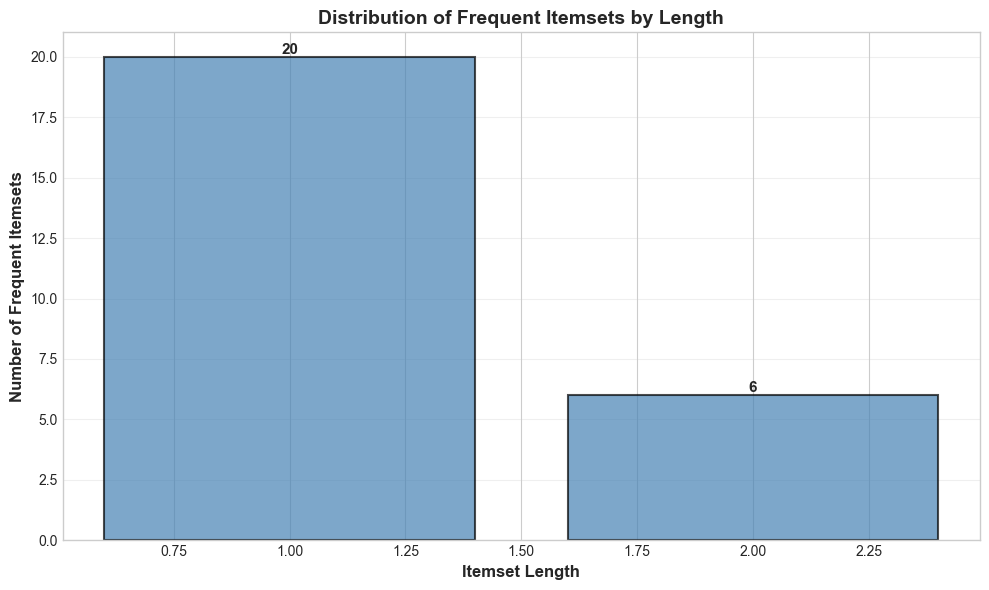

In [13]:
# Visualize itemset distribution
fig, ax = plt.subplots(figsize=(10, 6))
length_counts = frequent_itemsets['length'].value_counts().sort_index()
bars = ax.bar(length_counts.index, length_counts.values, color='steelblue',
              alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Itemset Length', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Frequent Itemsets', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Frequent Itemsets by Length', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars, length_counts.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('association_rules_results/itemset_distribution_mlxtend.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Generate Association Rules

In [14]:
# Generate association rules
print("Generating association rules...\n")

rules = association_rules(frequent_itemsets,
                         metric="confidence",
                         min_threshold=MIN_CONFIDENCE)

print(f"Total rules generated: {len(rules)}")

if len(rules) > 0:
    print(f"\nRule Statistics:")
    print("=" * 60)
    print(f"Average confidence: {rules['confidence'].mean():.3f}")
    print(f"Average lift: {rules['lift'].mean():.3f}")
    print(f"Average support: {rules['support'].mean():.4f}")
    print(f"Average conviction: {rules['conviction'].replace([np.inf, -np.inf], np.nan).mean():.3f}")

Generating association rules...

Total rules generated: 8

Rule Statistics:
Average confidence: 0.592
Average lift: 2.522
Average support: 0.0714
Average conviction: 2.218


In [15]:
# Display top rules by different metrics
if len(rules) > 0:
    print("\nTop 10 Rules by Lift (Statistical Significance):")
    print("=" * 80)

    top_lift = rules.nlargest(10, 'lift')
    for i, (idx, row) in enumerate(top_lift.iterrows(), 1):
        ant = ', '.join(list(row['antecedents']))[:50]
        cons = ', '.join(list(row['consequents']))[:50]
        print(f"\n{i}. {ant}")
        print(f"   → {cons}")
        print(f"   Lift: {row['lift']:.3f} | Confidence: {row['confidence']:.3f} | Support: {row['support']:.4f}")


Top 10 Rules by Lift (Statistical Significance):

1. fonctions de plusieurs variables relles : imites,c
   → probabilites : rappels de cours et exercices corri
   Lift: 4.028 | Confidence: 0.440 | Support: 0.0924

2. probabilites : rappels de cours et exercices corri
   → fonctions de plusieurs variables relles : imites,c
   Lift: 4.028 | Confidence: 0.846 | Support: 0.0924

3. eléments de la théorie des probabilités t.1
   → fonctions de plusieurs variables relles : imites,c
   Lift: 2.856 | Confidence: 0.600 | Support: 0.0252

4. exercices en langage c++ : 178 exercices corrigés
   → algebre 1 : rappels de cours et exercices avec sol
   Lift: 2.349 | Confidence: 0.750 | Support: 0.0252

5. tout sur r : ensemble des nombres reels structures
   → algebre 1 : rappels de cours et exercices avec sol
   Lift: 2.237 | Confidence: 0.714 | Support: 0.0420

6. algebre 1 : rappels de cours et exercices avec sol
   → cours d'algèbre et exercices corrigés
   Lift: 1.670 | Confidence: 0.421 | Sup

## 7. Rule Evaluation and Analysis

In [16]:
if len(rules) > 0:
    # Metrics summary
    metrics_summary = pd.DataFrame({
        'Metric': ['Support', 'Confidence', 'Lift', 'Leverage', 'Conviction'],
        'Mean': [
            rules['support'].mean(),
            rules['confidence'].mean(),
            rules['lift'].mean(),
            rules['leverage'].mean(),
            rules['conviction'].replace([np.inf, -np.inf], np.nan).mean()
        ],
        'Median': [
            rules['support'].median(),
            rules['confidence'].median(),
            rules['lift'].median(),
            rules['leverage'].median(),
            rules['conviction'].replace([np.inf, -np.inf], np.nan).median()
        ],
        'Min': [
            rules['support'].min(),
            rules['confidence'].min(),
            rules['lift'].min(),
            rules['leverage'].min(),
            rules['conviction'].replace([np.inf, -np.inf], np.nan).min()
        ],
        'Max': [
            rules['support'].max(),
            rules['confidence'].max(),
            rules['lift'].max(),
            rules['leverage'].max(),
            rules['conviction'].replace([np.inf, -np.inf], np.nan).max()
        ]
    })

    print("\nMetrics Summary:")
    print("=" * 80)
    print(metrics_summary.to_string(index=False))


Metrics Summary:
    Metric     Mean   Median      Min      Max
   Support 0.071429 0.067227 0.025210 0.134454
Confidence 0.591675 0.566667 0.421053 0.846154
      Lift 2.522421 2.292763 1.342105 4.027692
  Leverage 0.038424 0.038592 0.006426 0.069487
Conviction 2.218313 1.782713 1.191176 5.134454


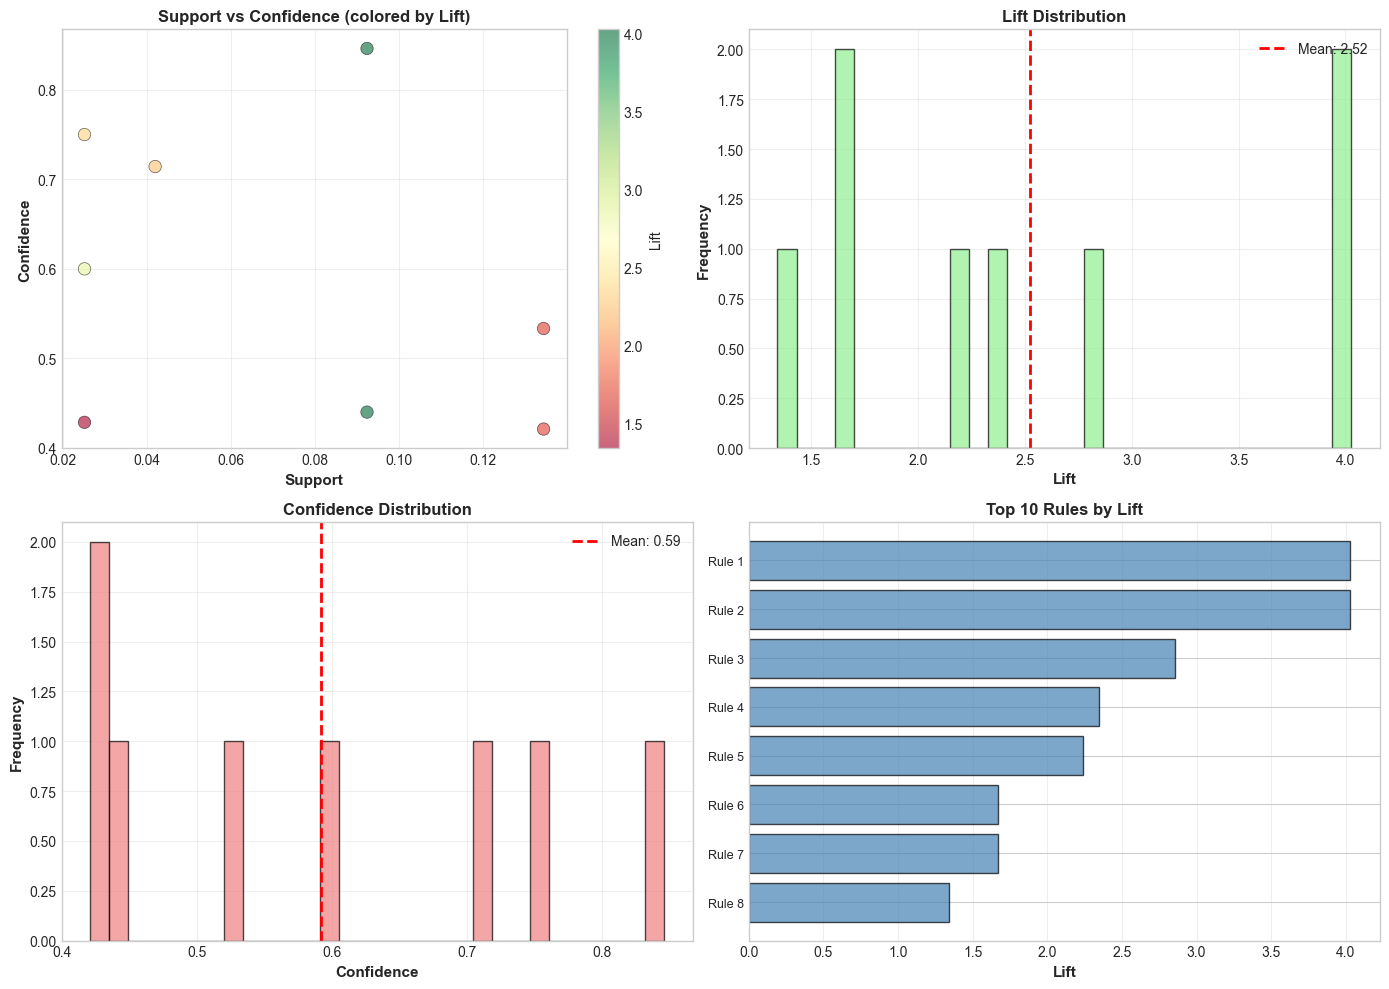

In [17]:
# Visualize rule metrics
if len(rules) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Support-Confidence scatter
    scatter = axes[0, 0].scatter(rules['support'], rules['confidence'],
                                 c=rules['lift'], cmap='RdYlGn', s=80,
                                 alpha=0.6, edgecolors='black', linewidth=0.5)
    axes[0, 0].set_xlabel('Support', fontsize=11, fontweight='bold')
    axes[0, 0].set_ylabel('Confidence', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Support vs Confidence (colored by Lift)',
                         fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0, 0], label='Lift')

    # Lift distribution
    axes[0, 1].hist(rules['lift'], bins=30, color='lightgreen',
                    alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(rules['lift'].mean(), color='red', linestyle='--',
                       linewidth=2, label=f"Mean: {rules['lift'].mean():.2f}")
    axes[0, 1].set_xlabel('Lift', fontsize=11, fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[0, 1].set_title('Lift Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Confidence distribution
    axes[1, 0].hist(rules['confidence'], bins=30, color='lightcoral',
                    alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(rules['confidence'].mean(), color='red', linestyle='--',
                       linewidth=2, label=f"Mean: {rules['confidence'].mean():.2f}")
    axes[1, 0].set_xlabel('Confidence', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Confidence Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Top rules by lift
    top_lift = rules.nlargest(10, 'lift')
    y_pos = np.arange(len(top_lift))
    axes[1, 1].barh(y_pos, top_lift['lift'].values, color='steelblue',
                    alpha=0.7, edgecolor='black')
    axes[1, 1].set_yticks(y_pos)
    axes[1, 1].set_yticklabels([f"Rule {i+1}" for i in range(len(top_lift))], fontsize=9)
    axes[1, 1].set_xlabel('Lift', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Top 10 Rules by Lift', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    axes[1, 1].invert_yaxis()

    plt.tight_layout()
    plt.savefig('association_rules_results/rule_metrics_mlxtend.png', dpi=300, bbox_inches='tight')
    plt.show()

## 8. Building the Recommendation System

In [18]:
def build_recommendation_system(rules, min_lift=1.0):
    """
    Build a recommendation system from high-quality rules.
    Filter rules by lift > 1 (positive correlation).
    """
    print("Building Recommendation System")
    print("=" * 60)

    if rules is None or len(rules) == 0:
        print("No rules available")
        return None

    print(f"Filtering high-quality rules with Lift > {min_lift}")

    quality_rules = rules[rules['lift'] > min_lift].copy()
    quality_rules = quality_rules.sort_values('lift', ascending=False)

    print(f"High-quality rules: {len(quality_rules)} / {len(rules)}")

    if len(quality_rules) == 0:
        print(f"No rules with lift > {min_lift}")
        return None

    # Build recommendation dictionary
    recommendations = defaultdict(list)

    for idx, row in quality_rules.iterrows():
        for ant_item in row['antecedents']:
            for cons_item in row['consequents']:
                recommendations[ant_item].append({
                    'book': cons_item,
                    'confidence': row['confidence'],
                    'lift': row['lift'],
                    'support': row['support']
                })

    print(f"\nRecommendation system built for {len(recommendations)} books")

    return dict(recommendations)

In [19]:
# Build recommendation system
recommendations = build_recommendation_system(rules, min_lift=1.0)

if recommendations:
    print(f"\nRecommendation system statistics:")
    rec_counts = [len(recs) for recs in recommendations.values()]
    print(f"  Books with recommendations: {len(recommendations)}")
    print(f"  Average recommendations per book: {np.mean(rec_counts):.1f}")
    print(f"  Max recommendations for a book: {max(rec_counts)}")

Building Recommendation System
Filtering high-quality rules with Lift > 1.0
High-quality rules: 8 / 8

Recommendation system built for 8 books

Recommendation system statistics:
  Books with recommendations: 8
  Average recommendations per book: 1.0
  Max recommendations for a book: 1


## 9. Recommendation Examples

In [20]:
def get_recommendations(book_title, recommendations, top_n=5):
    """
    Get top recommendations for a given book.
    """
    if book_title not in recommendations:
        return None

    recs = recommendations[book_title]
    # Sort by lift then confidence
    recs_sorted = sorted(recs, key=lambda x: (x['lift'], x['confidence']), reverse=True)

    return recs_sorted[:top_n]


def display_recommendations(book_title, recommendations, top_n=5):
    """
    Display recommendations for a given book.
    """
    print(f"\nRecommendations for:")
    print(f"'{book_title}'")
    print("=" * 80)

    recs = get_recommendations(book_title, recommendations, top_n)

    if recs is None:
        print("No recommendations available for this book.")
        return

    for i, rec in enumerate(recs, 1):
        print(f"\n{i}. {rec['book']}")
        print(f"   Confidence: {rec['confidence']:.3f} | Lift: {rec['lift']:.3f} | Support: {rec['support']:.4f}")

In [21]:
# Show recommendations for top books
if recommendations:
    # Get books with most recommendations
    items_sorted = sorted(recommendations.keys(),
                         key=lambda x: len(recommendations[x]),
                         reverse=True)

    print("\n" + "=" * 80)
    print("RECOMMENDATION EXAMPLES")
    print("=" * 80)

    for book in items_sorted[:5]:
        display_recommendations(book, recommendations, top_n=5)
        print()


RECOMMENDATION EXAMPLES

Recommendations for:
'fonctions de plusieurs variables relles : imites,continuite,differentiabilité et.... cours détaillé et exercices résolus'

1. probabilites : rappels de cours et exercices corriges
   Confidence: 0.440 | Lift: 4.028 | Support: 0.0924


Recommendations for:
'probabilites : rappels de cours et exercices corriges'

1. fonctions de plusieurs variables relles : imites,continuite,differentiabilité et.... cours détaillé et exercices résolus
   Confidence: 0.846 | Lift: 4.028 | Support: 0.0924


Recommendations for:
'eléments de la théorie des probabilités t.1'

1. fonctions de plusieurs variables relles : imites,continuite,differentiabilité et.... cours détaillé et exercices résolus
   Confidence: 0.600 | Lift: 2.856 | Support: 0.0252


Recommendations for:
'exercices en langage c++ : 178 exercices corrigés'

1. algebre 1 : rappels de cours et exercices avec solutions
   Confidence: 0.750 | Lift: 2.349 | Support: 0.0252


Recommendations for:
'to

## 10. Interactive Recommendation Lookup

In [22]:
# Function to search for books and get recommendations
def search_and_recommend(search_term, recommendations, top_n=5):
    """
    Search for books matching a term and return recommendations as a list.
    """
    # Find matching books
    matching_books = [
        book for book in recommendations.keys()
        if search_term.lower() in book.lower()
    ]

    if not matching_books:
        return []

    results = []

    for book in matching_books:
        recs = recommendations.get(book, [])[:top_n]

        results.append({
            "searched_book": book,
            "recommended_books": [r['book'] for r in recs]
        })

    return results


# Example searches
if recommendations:
    results = search_and_recommend("exercices", recommendations)

    for r in results:
        print(f"\n📘 {r['searched_book']}")
        for book in r['recommended_books']:
            print(f"   → {book}")



📘 fonctions de plusieurs variables relles : imites,continuite,differentiabilité et.... cours détaillé et exercices résolus
   → probabilites : rappels de cours et exercices corriges

📘 probabilites : rappels de cours et exercices corriges
   → fonctions de plusieurs variables relles : imites,continuite,differentiabilité et.... cours détaillé et exercices résolus

📘 exercices en langage c++ : 178 exercices corrigés
   → algebre 1 : rappels de cours et exercices avec solutions

📘 algebre 1 : rappels de cours et exercices avec solutions
   → cours d'algèbre et exercices corrigés

📘 cours d'algèbre et exercices corrigés
   → algebre 1 : rappels de cours et exercices avec solutions

📘 mathématiques rappels et cours exercices résolus
   → algebre 1 : rappels de cours et exercices avec solutions


## 11. Export Results

In [23]:
# Export association rules
if len(rules) > 0:
    rules_export = rules.copy()
    rules_export['antecedents'] = rules_export['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules_export['consequents'] = rules_export['consequents'].apply(lambda x: ', '.join(list(x)))
    rules_export.to_csv('association_rules_results/association_rules.csv', index=False)
    print("✓ Saved: association_rules_results/association_rules.csv")

# Export frequent itemsets
if len(frequent_itemsets) > 0:
    freq_export = frequent_itemsets.copy()
    freq_export['itemsets'] = freq_export['itemsets'].apply(lambda x: ', '.join(list(x)))
    freq_export.to_csv('association_rules_results/frequent_itemsets.csv', index=False)
    print("✓ Saved: association_rules_results/frequent_itemsets.csv")

# Export recommendation examples
if recommendations:
    items_sorted = sorted(recommendations.keys(),
                         key=lambda x: len(recommendations[x]),
                         reverse=True)[:10]

    with open('association_rules_results/recommendation_examples.txt', 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("BOOK RECOMMENDATION EXAMPLES\n")
        f.write("=" * 80 + "\n\n")

        for i, book in enumerate(items_sorted, 1):
            f.write(f"{i}. If reader borrowed:\n")
            f.write(f"   '{book}'\n\n")
            f.write(f"   RECOMMENDATIONS:\n")

            recs = get_recommendations(book, recommendations, top_n=5)

            if recs:
                for j, rec in enumerate(recs, 1):
                    f.write(f"\n   {j}. {rec['book']}\n")
                    f.write(f"      Confidence: {rec['confidence']:.3f} | ")
                    f.write(f"Lift: {rec['lift']:.3f} | ")
                    f.write(f"Support: {rec['support']:.4f}\n")

            f.write("\n" + "-" * 80 + "\n\n")

    print("✓ Saved: association_rules_results/recommendation_examples.txt")

print("\n✓ All results exported successfully!")

✓ Saved: association_rules_results/association_rules.csv
✓ Saved: association_rules_results/frequent_itemsets.csv
✓ Saved: association_rules_results/recommendation_examples.txt

✓ All results exported successfully!


## Summary

This notebook used the MLxtend library to efficiently implement association rule mining:

1. **Data Preparation**: Loaded book checkout transactions and converted to binary matrix
2. **Apriori Algorithm**: Used MLxtend's optimized Apriori implementation
3. **Rule Generation**: Generated association rules with automatic metric calculation
4. **Recommendation System**: Built a book recommendation system based on high-quality rules
5. **Evaluation**: Analyzed rules using support, confidence, lift, leverage, and conviction

### Advantages of Using MLxtend:
- **Efficiency**: Highly optimized C-based implementation
- **Simplicity**: Clean API with automatic metric calculation
- **Completeness**: Includes all standard evaluation metrics
- **Reliability**: Well-tested and maintained library

The recommendation system identifies books that are frequently borrowed together, enabling data-driven suggestions for library patrons.